In [3]:
import numpy  as np
import pandas as pd
import data_tools
import itertools
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.stats import norm
from Models.models import *
from time import time
from quadtree import Point, Rect, QuadTree

## Some functions 

In [4]:
ts = pd.read_csv('Preprocessed_data/ts.csv')

log_diff_prices = ts.price.values
log_diff_prices = np.array(log_diff_prices, dtype=float)
log_diff_prices = np.diff(np.log(log_diff_prices))
log_diff_prices = np.concatenate((np.array([0]), log_diff_prices))
ts['log_diff_prices'] = log_diff_prices

yearmonth = list(ts['yearmonth'])
x_label   = data_tools.from_index_to_dates(yearmonth)

ts['X'] = np.zeros(ts.shape[0])

for t in ts.index:
    if t == 0:
        continue
        
    curr_price = ts.loc[t  , 'price']
    prev_price = ts.loc[t-1, 'price'] 
    
    ts.loc[t,'X'] = residual(prev_price,curr_price,t)

eta = 0.5
zd  = 105.69451612903225
r   = 0.0041

discount = 1/(1+r)

elev_stor = zip(ts.elevation.values,ts.storage.values)
elev_stor = sorted(elev_stor, key=lambda x: (x[1],x[0]))

def get_middle_points(x):
    x = np.array(x)
    return (x[:-1] + x[1:])/2


def pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation):
    
    expected_storage = model_storage(model_inflow, inflow , model_evaporation, t, storage, q) # this may not be needed if forecast is done.
    
    return eta * q * ((z(storage, elev_stor) + z(expected_storage,elev_stor))/2 - zd) * P

#def inter_0_extremes()

## Define inputs

### Grids

In [175]:
N = 20 # For the storage grid
M = 20 # For the price grid
L = 20 # For the outflow grid
S = 20 # For the states


P_min = 0.020
P_max = 0.250

I_min = 1750
I_max = 3250
boundaries = [2000,3000]

q_min = 0
q_max = 245

price_grid   = get_middle_points(np.arange(P_min, P_max+ 2**-15, (P_max - P_min)/M))
storage_grid = get_middle_points(np.arange(I_min, I_max+ 2**-15, (I_max - I_min)/N))


rho = 2.33
K = 10 # number of shocks in the storage grid
J = 10 # number of shocks in the prices grid

shocks_storage  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ K))

dist_shocks_storage = (shocks_storage[1] - shocks_storage[0])/2
prob_shocks_storage = norm.cdf(shocks_storage[:] + dist_shocks_storage) - norm.cdf(shocks_storage[:] - dist_shocks_storage)

shocks_prices  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ J))

dist_shocks_prices = (shocks_prices[1] - shocks_prices[0])/2
prob_shocks_prices = norm.cdf(shocks_prices[:] + dist_shocks_prices) - norm.cdf(shocks_prices[:] - dist_shocks_prices)



outflow_grid = np.arange(q_min, q_max+ 2**-15, (q_max - q_min)/L) # L+1 elements

V0 = np.zeros((S+1,N,M))
V1 = np.zeros((S+1,N,M))

policy = np.zeros((S,N,M))

### Forecast inflow and storage

In [133]:
time_0 = ts.shape[0]
ts_forecast = ts.copy()

for i in range(S):
    
    current_time = time_0 + i
    
    prev_inflow  = ts_forecast.loc[current_time - 1, 'inflow' ]
    prev_storage = ts_forecast.loc[current_time - 1, 'storage']
    
    current_storage = model_storage(model_inflow,prev_inflow, model_evaporation, current_time, prev_storage, prev_inflow)
    current_inflow  = model_inflow(current_time, prev_inflow)
    
    ts_forecast.loc[current_time,'storage'] = current_storage
    ts_forecast.loc[current_time,'inflow']  = current_inflow

### Forecast prices

In [134]:
# Forecasting Prices M steps ahead
for i in range(S):
    
    current_time = time_0 + i
    
    prev     = ts_forecast.loc[current_time-1,  'price']
    prev_x   = ts_forecast.loc[current_time-1,  'X']
    prev_y_x = ts_forecast.loc[current_time-12, 'X']
    
    log_P      = model_log_prices(current_time,prev, prev_x, prev_y_x)
    curr_price = np.exp(log_P)
    
    ts_forecast.loc[current_time,'price'] = curr_price
    
    X = residual(prev,curr_price,current_time)
    ts_forecast.loc[current_time,'X'] = X

## Algorithm 

In [8]:
pi_call = lambda storage, inflow, t, P, q: pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation)

In [9]:
def pi_call_0(storage, inflow, t, P, q):
    if storage > 2e4 or storage < 3e4:
        return pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation) 
    else:
        return -1e7

In [176]:
max_ite = 20
ite     = 0
tol     = 2**-3

A = np.outer(prob_shocks_storage,prob_shocks_prices)


t0 = time()
while ite < max_ite:
    
    for s in range(S):
        current_time = time_0 + s
        for n in range(N):
            inflow       = ts_forecast.loc[current_time,'inflow']
            storage      = storage_grid[n]
            
            for m in range(M):
                price = price_grid[m]
                rewards = []
                for q in outflow_grid:
                    input_next_storage = [model_inflow, inflow , model_evaporation, current_time,
                                          storage, q, model_storage]
                    input_next_price   = [current_time, price]
                    
#                    s_next = s+1 % 12 # The value grid is ciclic
                    s_next = s+1
                    next_state_value, under_storage, over_storage = future_payments(V0[s_next],A, shocks_storage, shocks_prices,
                                                                            input_next_storage, input_next_price, 
                                                                            price_grid, storage_grid, boundaries)
                    
                    if under_storage: 
                        reward = - q # the lower the water usage the better when under storage
                    elif over_storage:
                        if q == 0:
                            q = 2**-8
                        reward = - 1/q # the more water usage the better when over storage
                                       # in both cases the value is negativo to discourage this kind of state
                    else:
                        reward = pi_call_0(storage, inflow, current_time, price, q) + discount * next_state_value

                    rewards.append(reward)
                
                policy[s,n,m] = outflow_grid[np.argmax(rewards)]
                V1[s,n,m]     = np.max(rewards) 
#                 policy[s % 12,n,m] = outflow_grid[np.argmax(rewards)]
#                 V1[s % 12,n,m]     = np.max(rewards) 
    
    error = np.max(np.abs(V0-V1))/np.max(V1)
    if error < tol:
        V0 = V1.copy()
        print(time()-t0)
        print(f'Iteration: {ite}')
        print(f'Error is: {error}')
        break
        
    V0   = V1.copy()
    ite += 1
    print(time()-t0)
    print(f'Iteration: {ite}')
    print(f'Error is: {error}')
    print('='*50)

34.05827593803406
Iteration: 1
Error is: 1.0
68.0030870437622
Iteration: 2
Error is: 0.47590862904575987
101.92572808265686
Iteration: 3
Error is: 0.26959023165397533
135.98305869102478
Iteration: 3
Error is: 0.11237983992212738


In [190]:
np.savetxt('Results/V0.txt', V0[0])
np.savetxt('Results/policy.txt', policy[0])

In [156]:
def plot_policy(storage_grid, price_grid, policy):
    x,y = np.meshgrid(storage_grid, price_grid)
    policy = np.transpose(policy)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(x,y,policy, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price ($/kwh)')
    ax.set_zlabel('outflow (m^3/s)')
    ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (06/2020)')
    #plt.savefig('Figures/3d_06.pdf', format='pdf')
    plt.show()

In [178]:
policy[2]

array([[245., 245., 245., 245., 245., 245., 245., 245., 245., 245., 245.,
        245., 245., 245., 245., 245., 245., 245., 245., 245.],
       [245., 245., 245., 245., 245., 245., 245., 245., 245., 245., 245.,
        245., 245., 245., 245., 245., 245., 245., 245., 245.],
       [245., 245., 245., 245., 245., 245., 245., 245., 245., 245., 245.,
        245., 245., 245., 245., 245., 245., 245., 245., 245.],
       [245., 245., 245., 245., 245., 245., 245., 245., 245., 245., 245.,
        245., 245., 245., 245., 245., 245., 245., 245., 245.],
       [245., 245., 245., 245., 245., 245., 245., 245., 245., 245., 245.,
        245., 245., 245., 245., 245., 245., 245., 245., 245.],
       [245., 245., 245., 245., 245., 245., 245., 245., 245., 245., 245.,
        245., 245., 245., 245., 245., 245., 245., 245., 245.],
       [245., 245., 245., 245., 245., 245., 245., 245., 245., 245., 245.,
        245., 245., 245., 245., 245., 245., 245., 245., 245.],
       [245., 245., 245., 245., 245., 245

<ipython-input-156-bcfbdabeedc5>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


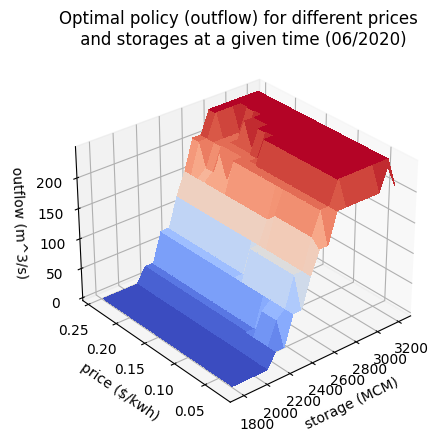

In [169]:
plot_policy(storage_grid,price_grid,policy[6])

<ipython-input-156-bcfbdabeedc5>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


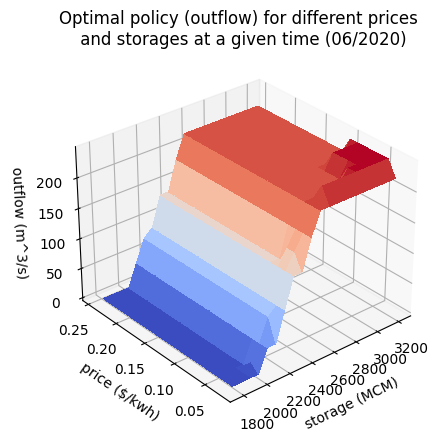

0.14037487533474619


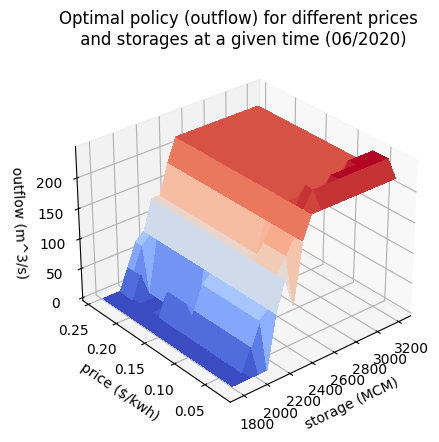

0.14385443815166896


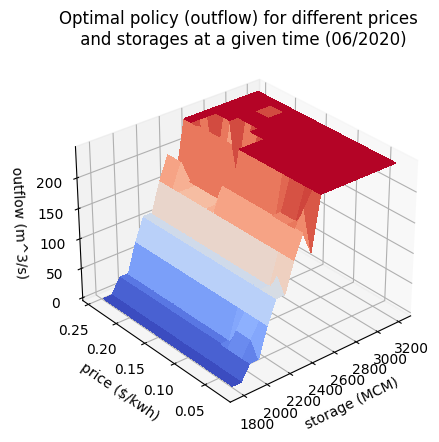

0.15122865236220265


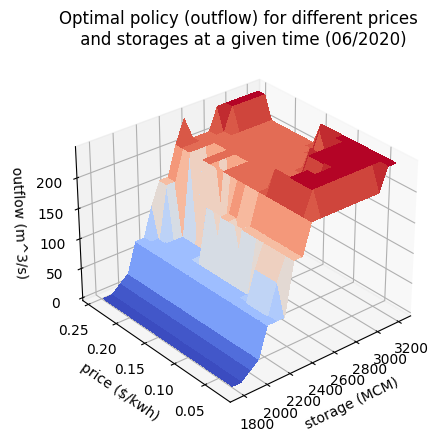

0.1616423801106514


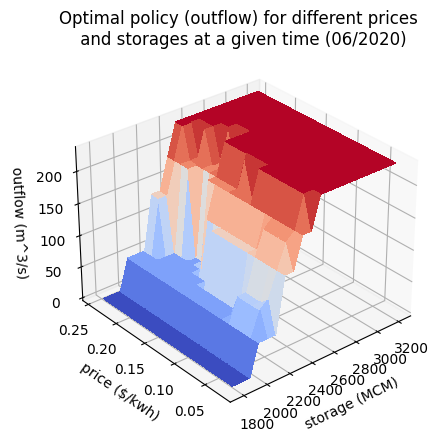

0.17244851285235038


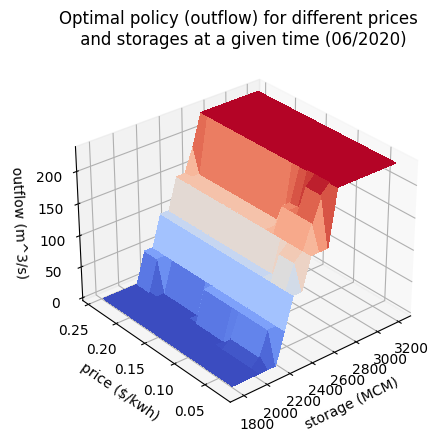

0.18060177454789575


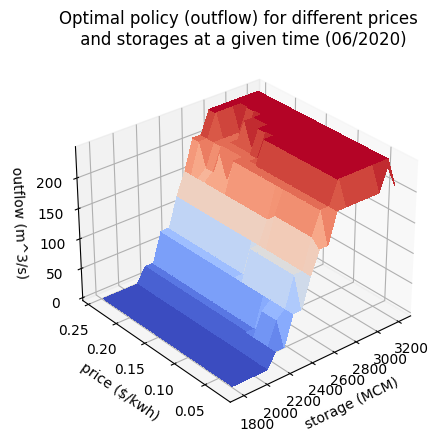

0.18357991321421507


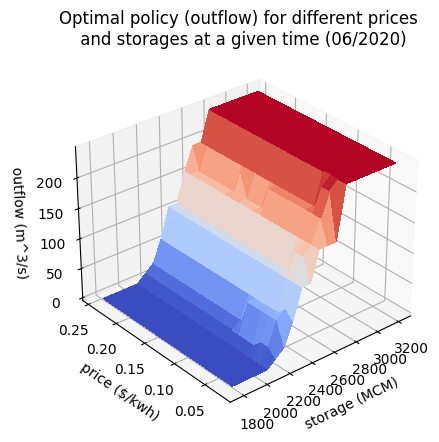

0.18053578392348432


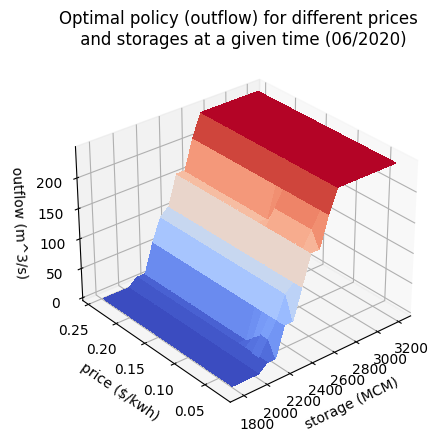

0.1722794922951063


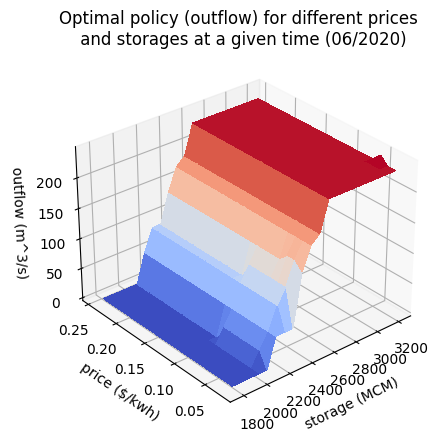

0.16236629418823195


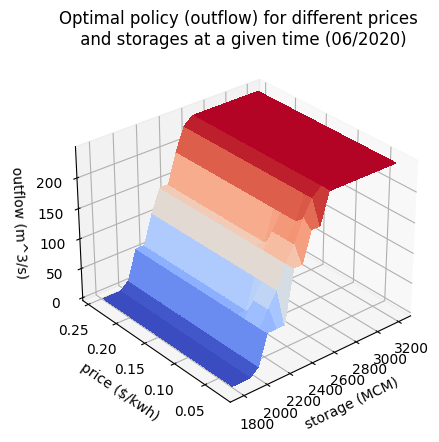

0.15388695875771313


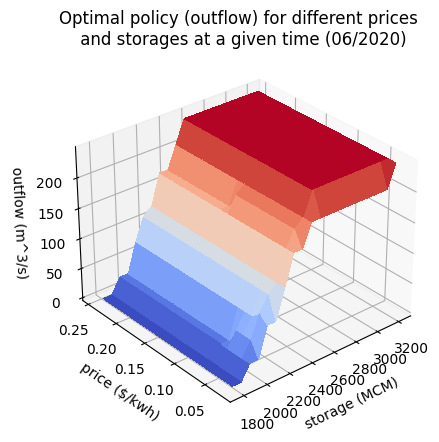

0.1483258840707132


In [177]:
for s in range(12):
    plot_policy(storage_grid,price_grid,policy[s])
    print(ts_forecast.loc[time_0+s, 'price'])

In [158]:
step_price   = price_grid[1]   - price_grid[0]
step_storage = storage_grid[1] - storage_grid[0]

coord = lambda x,y: (int((x - storage_grid[0])/step_storage) * step_storage + storage_grid[0], int((y - price_grid[0])/step_price) * step_price + price_grid[0])

coord_array = lambda x,y: (((x - storage_grid[0])/step_storage + 0.5).astype(int), ((y - price_grid[0])/step_price).astype(int))
                           
def prepro_coord_array(x,y):
    x[x<I_min] = I_min
    x[x>I_max] = I_max
    
    y[y<P_min] = P_min
    y[y>P_max] = P_max
    return x,y

def future_payments(V,A,shocks_storage, shocks_price, input_next_storage, input_next_price, price_grid, storage_grid,boundaries):
    K = len(shocks_storage)
    J = len(shocks_price  )
    
    future_payment = np.zeros((K,J))
        
    future_storage = next_storage(*input_next_storage, shocks_storage)
    cond = np.logical_or(future_storage < boundaries[0], future_storage > boundaries[1])
    future_price   = next_price(  *input_next_price  , shocks_price)
    cond = np.meshgrid(cond,future_price)[0]
    
    if future_storage.min() < boundaries[0]:
        return 0, True, False
    elif future_storage.max() > boundaries[1]:
        return 0, False, True

    future_storage, future_price = prepro_coord_array(future_storage, future_price)
    future_storage, future_price = coord_array(future_storage, future_price) # at this point future_price is the coord in V
    
    future_storage ,future_price = np.meshgrid(future_storage, future_price)
    
    
    future_payment = np.multiply(V[future_storage, future_price], A)
    
    return np.sum(future_payment[~cond]), False, False

### Working with the policy towards an optimal solution

In [ ]:
print(price_grid)
print(storage_grid)

[0.02575 0.03725 0.04875 0.06025 0.07175 0.08325 0.09475 0.10625 0.11775
 0.12925 0.14075 0.15225 0.16375 0.17525 0.18675 0.19825 0.20975 0.22125
 0.23275 0.24425]
[1765. 1795. 1825. 1855. 1885. 1915. 1945. 1975. 2005. 2035. 2065. 2095.
 2125. 2155. 2185. 2215. 2245. 2275. 2305. 2335. 2365. 2395. 2425. 2455.
 2485. 2515. 2545. 2575. 2605. 2635. 2665. 2695. 2725. 2755. 2785. 2815.
 2845. 2875. 2905. 2935. 2965. 2995. 3025. 3055. 3085. 3115. 3145. 3175.
 3205. 3235.]


In [140]:
print(input_storage)
print(storage_coor)
print(input_price)
print(price_coor)

2507.876580645161
5
0.142
8


In [240]:
ts.loc[time_0-1,'outflow']

1.4231612903225803

In [26]:
outflow = ts.loc[time_0-1,'outflow']
storage = ts.loc[time_0-1,'storage']

storage_price_outflow = np.zeros((3,S))

for s in range(S):
    
    current_time = time_0 + s
        
    input_next_storage = [model_inflow, ts_forecast.loc[current_time - 1,'inflow'] , model_evaporation, current_time,
                                          storage, outflow, model_storage] # Outflow changed from IV loop
    
    storage = next_storage(*input_next_storage, 0)
    
    price   = next_price(t,ts_forecast.loc[current_time - 1,'price'], 0)
    
    x = closest_argument(storage, storage_grid)
    y = closest_argument(price  , price_grid)
    
    outflow = policy[s,x,y] # (MCM)
    
    storage_price_outflow[0,s] = storage
    storage_price_outflow[1,s] = price
    storage_price_outflow[2,s] = 2.592 * outflow


In [38]:
storage_price_outflow[0,:]

array([2648.10496998, 2669.80366335, 2587.64401949, 2745.64912763,
       2994.11635138, 2661.38946153, 2527.55410467, 1998.39287942,
       2059.44134689, 2030.1852985 , 2202.54373455, 2308.56485761,
       2287.88462921, 2378.59178847, 2615.121339  , 2709.87079377,
       2958.39076841, 2625.6750833 , 2555.34610641, 2026.18538669,
       2087.23396153, 2057.97793595, 2103.32837685, 2209.34950093])

In [40]:
storage_price_outflow[1,:]

array([0.13869229, 0.13710502, 0.14050353, 0.14770597, 0.15787713,
       0.16843154, 0.17639489, 0.17930365, 0.17633043, 0.16826646,
       0.15858418, 0.15030236, 0.14487082, 0.14443142, 0.14696683,
       0.15172352, 0.15737779, 0.16254858, 0.1658684 , 0.16642891,
       0.16415446, 0.16000393, 0.15508234, 0.15070439])

In [39]:
storage_price_outflow[2,:]

array([190.512, 317.52 ,  63.504,   0.   , 444.528, 190.512, 571.536,
         0.   , 127.008,   0.   , 127.008, 190.512, 127.008,   0.   ,
       127.008,   0.   , 444.528, 127.008, 571.536,   0.   , 127.008,
       127.008, 127.008, 444.528])

In [306]:
ts_forecast.loc[495,'inflow']

83.07485417194728

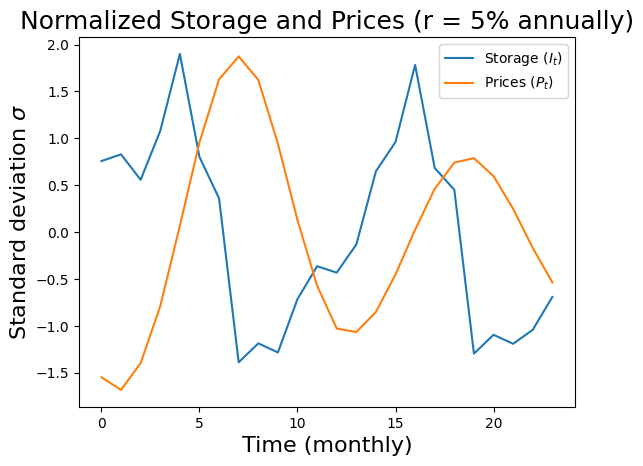

In [28]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]),label = 'Storage ($I_t$)')
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]),label = 'Prices ($P_t$)')
plt.legend()
plt.ylabel('Standard deviation $\sigma$',fontdict={'size': 16})
plt.xlabel('Time (monthly)',fontdict={'size': 16})
plt.title('Normalized Storage and Prices (r = 5% annually)',fontdict={'size': 18})
plt.savefig('Figures/storage_policy.pdf', format='pdf')
plt.show()

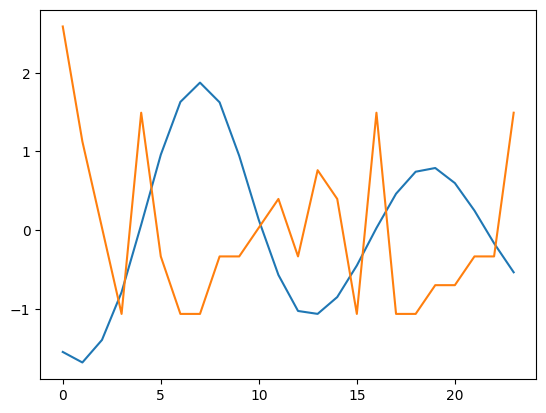

In [492]:
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]))
plt.plot((storage_price_outflow[2,:]-(np.mean(storage_price_outflow[2,:])))/np.std(storage_price_outflow[2,:]))
plt.show()

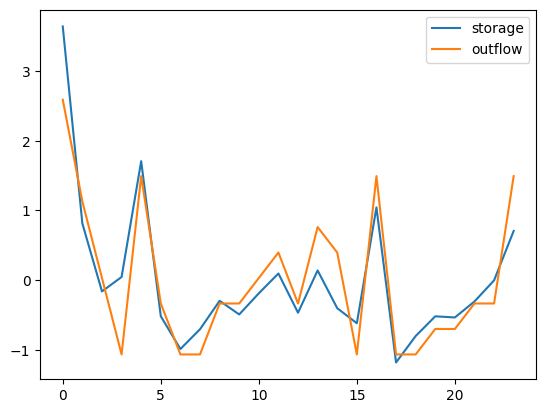

In [494]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]), label='storage')
plt.plot((storage_price_outflow[2,:]-(np.mean(storage_price_outflow[2,:])))/np.std(storage_price_outflow[2,:]), label='outflow')
plt.legend()
plt.show()

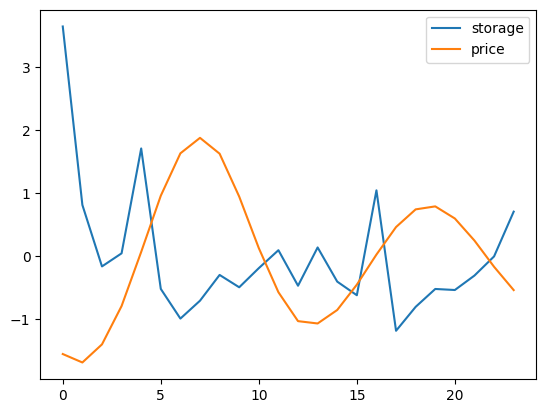

In [495]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]), label='storage')
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]), label='price')
plt.legend()
plt.show()

In [279]:
ts.loc[time_0-1,'storage']

2507.876580645161

In [283]:
2.592 * ts_forecast.loc[current_time - 1,'inflow']

113.34891251612903

In [284]:
next_storage(*input_next_storage, 0)

2648.104969975169

In [287]:
2.592 * model_inflow(current_time,ts_forecast.loc[current_time - 1,'inflow']) + 2507

2653.292026992198